# **Sign Language Classification**

## Problems Explaination
We are given all the different gasture images considered in ASL (Americal Sign Language) and we need to come up with a machine learning model wich can classifiy the images correctly ,or can tell us the class to which the given image belongs.
Basically we will be building a image classification model . 
<br>
## Data information
we are given 2 comma saperated file(.csv) each on them contains some rows and 785 columns
* from 2nd columns onwards each column represents the pixel values associated , representing a 28x28 grayscale image
* first column in each row represnts label with the image
* There are total 24 lables (in american sign language) A-I,K-Y means A-Z except J and Z

we will be using cnn to solve this problem .

# import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import accuracy_score,confusion_matrix
from keras.callbacks import ReduceLROnPlateau


In [2]:
#reading data
train_data = pd.read_csv("/sign_mnist_train.csv")
print(train_data.shape)
train_data.head()

(27455, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [3]:
test_data = pd.read_csv("/sign_mnist_test.csv")
print(test_data.shape)
test_data.head()

(7172, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


basically in our dataset we are given lable for the corrosponding gasture and 784 (28 x 28) pixel values represting an image <br>
* Training data contains 27455 images 
* test data contains 7172 images 

# Data preprocessing
* converting array to images(tensors)

* visulaizing lables and making sure that dataset is balanced
* performing one hot encoding for lables

In [4]:
y_train = train_data['label']
y_test = test_data['label']
del train_data['label']
del test_data['label']

In [5]:
unique_labels = y_train.unique()
unique_labels = np.sort(unique_labels)
unique_labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


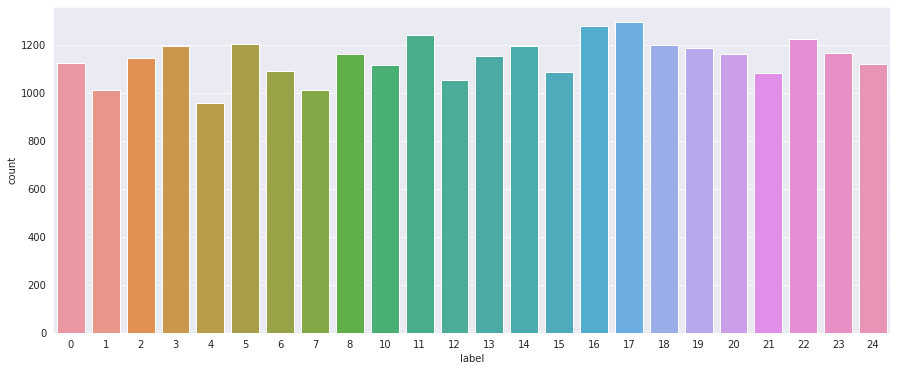

In [6]:
# visulaizing the data
plt.figure(figsize=(15,6))
sns.set_style("darkgrid");
sns.countplot(y_train);

This really nice visual tells us that there are nearly 1k examples for each class output so we can consider this dataset as a balanec dataset because there's no class suffering from very less or too much examples 

Now the question arrises that why we didnt check the same thing for test data .... and the ans is we dont really need that <span>&#128516;</span> .<br>
In our training set we check the balance of the data coz we want to learn our model perfactly for each class we dont want it to be biased for a subset of possible classes, while in test set the whole paper can be from linear algebra , no worries in that case


In [7]:
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

y_train[:2]

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]])

so basically `LabelBinarizer` performed OHE sort of stuff on our training data .<br>
Now let's write a function wich can take our array of images and can return a well shaped wranggled array .

In [8]:
def preprocess_image(x):
    
    """
    we know that the pixcel values lies between 0-255 but it is obsearved that models performs exceptionally well if we scale pixel values
    between 0-1"""
    x = x/255
    x = x.reshape(-1,28,28,1) # convertin it into 28 x 28 gray scaled image
    
    return x
    

In [9]:
train_x = preprocess_image(train_data.values)
test_x = preprocess_image(test_data.values)

let's write a function which<br>
* takes images array as input
* displays 10 images from it(first 10)

In [10]:
def show_images(images,labels):
    fig,ax = plt.subplots(2,5)
    fig.set_size_inches(10, 6)
    k =0
    for i in range(2):
        for j in range(5):
            ax[i,j].imshow(images[k] , cmap='gray')
            ax[i,j].set_title(str(unique_labels[np.argmax(y_train[k])]))
            k = k+1;
    plt.tight_layout()

    

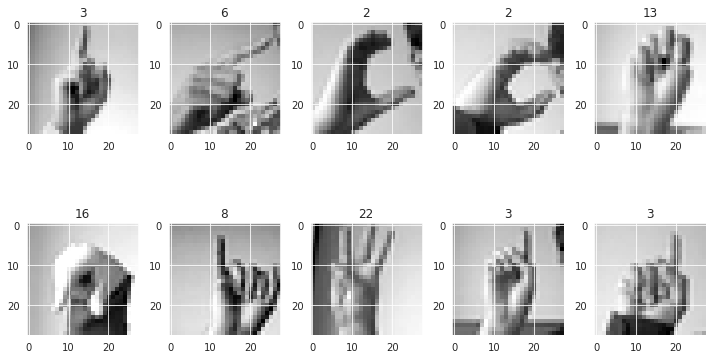

In [11]:
#let's see first 10 images from training set
show_images(train_x,y_train)

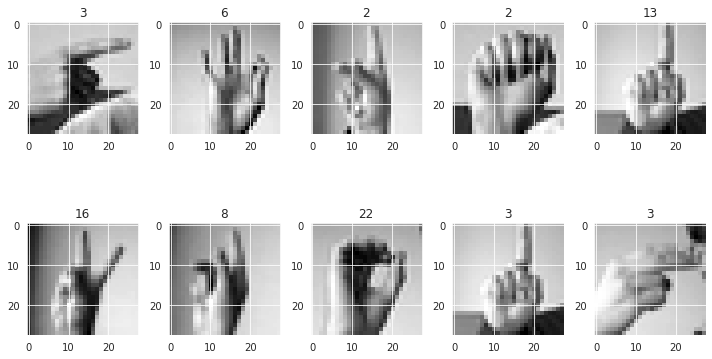

In [12]:
#let's visualize test images as well
show_images(test_x,y_test)

so far we have done a lot , we got our images ready right!

## Data Augmentation
Data augmentation is a strategy that enables practitioners to significantly increase the diversity of data available for training models, without actually collecting new data. Data augmentation techniques such as cropping, padding, and horizontal flipping are commonly used to train large neural networks.

This can expand our dataset artifically and make it robust , that couses variety in data and this can save us from overfitting.

In [13]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(train_x)

## Buidling the CNN model
we will be building a CNN model to classify images , as usual we will try a few of conv2d layers along with batchNormalization and regulization(dropout) and then fallten layer then dense layer .


In [14]:
def build_model(hp):  
  model = keras.Sequential([
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=75, max_value=200, step=25),
        kernel_size=(3,3),
        activation='relu',
        
        input_shape=(28,28,1)
    ),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same'),
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=50, max_value=125, step=25),
        kernel_size=(3,3),
        activation='relu',
    ),
    
    keras.layers.Dropout(
        rate = hp.Choice('drop_1_rate', values = [0.1,0.5])
    ),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same'),
    
    
    keras.layers.Conv2D(
        filters=hp.Int('conv_3_filter', min_value=25, max_value=75, step=25),
        kernel_size=(3,3),
        activation='relu',
    ),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same'),  
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=128, max_value=1024, step=32),
        activation='relu'
    ),
    keras.layers.Dropout(
        rate = hp.Choice('drop_2_rate', values = [0.1,0.3])
    ),
    keras.layers.Dense(24, activation='softmax')
  ])
  
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [15]:
tuner_search=RandomSearch(build_model,
                          objective='val_accuracy',
                          max_trials=5,directory='output',project_name="ASLdetection1")

In [16]:
tuner_search.search(train_x,y_train,epochs=5,validation_data = (test_x, y_test))

Trial 5 Complete [00h 00m 48s]
val_accuracy: 0.9291689991950989

Best val_accuracy So Far: 0.950362503528595
Total elapsed time: 00h 03m 33s


well,well well, what happened in above 3 cells , isn't it looking like a magic, or it's it's going over head, relax i'll try to explaing this
<br>
In the function `build_model` we build a cnn model , we spacified some layers and some of the hyperparameters are tuned using `keras-tuner` , it took each possible set of allowed parameters and trained a model and validated on test data , yep as simple as you read it.
have a look at <a href="https://keras-team.github.io/keras-tuner/documentation/hyperparameters/">keras-tuner</a>


ok now we have tired different models and it's time to extract the best model from `tuner_search` object ...let's do this 

In [17]:
model=tuner_search.get_best_models(num_models=1)[0] #this will give us the best tuned model

# Now let's create a callback 
A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training.

we will reduce learning rate when a metric has stopped improving.

Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.


In [18]:
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 3, verbose=1,factor=0.5, min_lr=0.00001)

now let's train the model 

In [19]:
history = model.fit(datagen.flow(train_x,y_train, batch_size = 128) 
                    ,epochs = 20
                    , validation_data = (test_x, y_test)
                    , callbacks = [lr_reduction])

Epoch 1/20
215/215 [==============================] - 10s 43ms/step - loss: 0.5274 - accuracy: 0.8658 - val_loss: 0.0335 - val_accuracy: 0.9893
Epoch 2/20
215/215 [==============================] - 9s 41ms/step - loss: 0.0680 - accuracy: 0.9777 - val_loss: 0.0532 - val_accuracy: 0.9838
Epoch 3/20
215/215 [==============================] - 9s 42ms/step - loss: 0.0478 - accuracy: 0.9844 - val_loss: 0.0540 - val_accuracy: 0.9774
Epoch 4/20
215/215 [==============================] - 9s 40ms/step - loss: 0.0355 - accuracy: 0.9887 - val_loss: 0.0048 - val_accuracy: 1.0000
Epoch 5/20
215/215 [==============================] - 8s 39ms/step - loss: 0.0283 - accuracy: 0.9904 - val_loss: 0.0054 - val_accuracy: 0.9993
Epoch 6/20
215/215 [==============================] - 9s 40ms/step - loss: 0.0225 - accuracy: 0.9922 - val_loss: 0.0078 - val_accuracy: 0.9972
Epoch 7/20
215/215 [==============================] - 10s 45ms/step - loss: 0.0204 - accuracy: 0.9930 - val_loss: 0.0665 - val_accuracy: 0.97

well, we got 100% accuracy on our test data .
# Analyse the trained model

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 100)       1000      
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 100)       400       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 100)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 75)        67575     
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 75)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 75)        300       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 75)          0

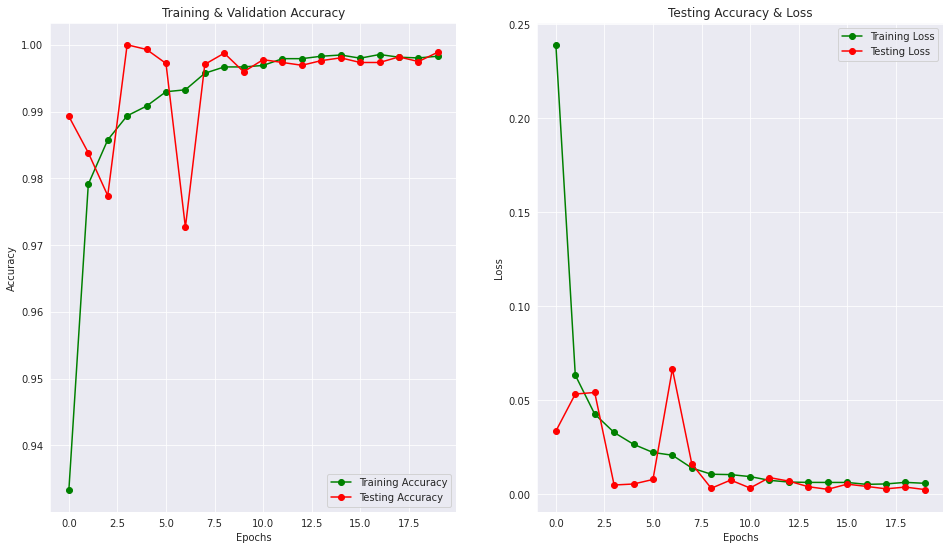

In [21]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

let's now plot the model architecture

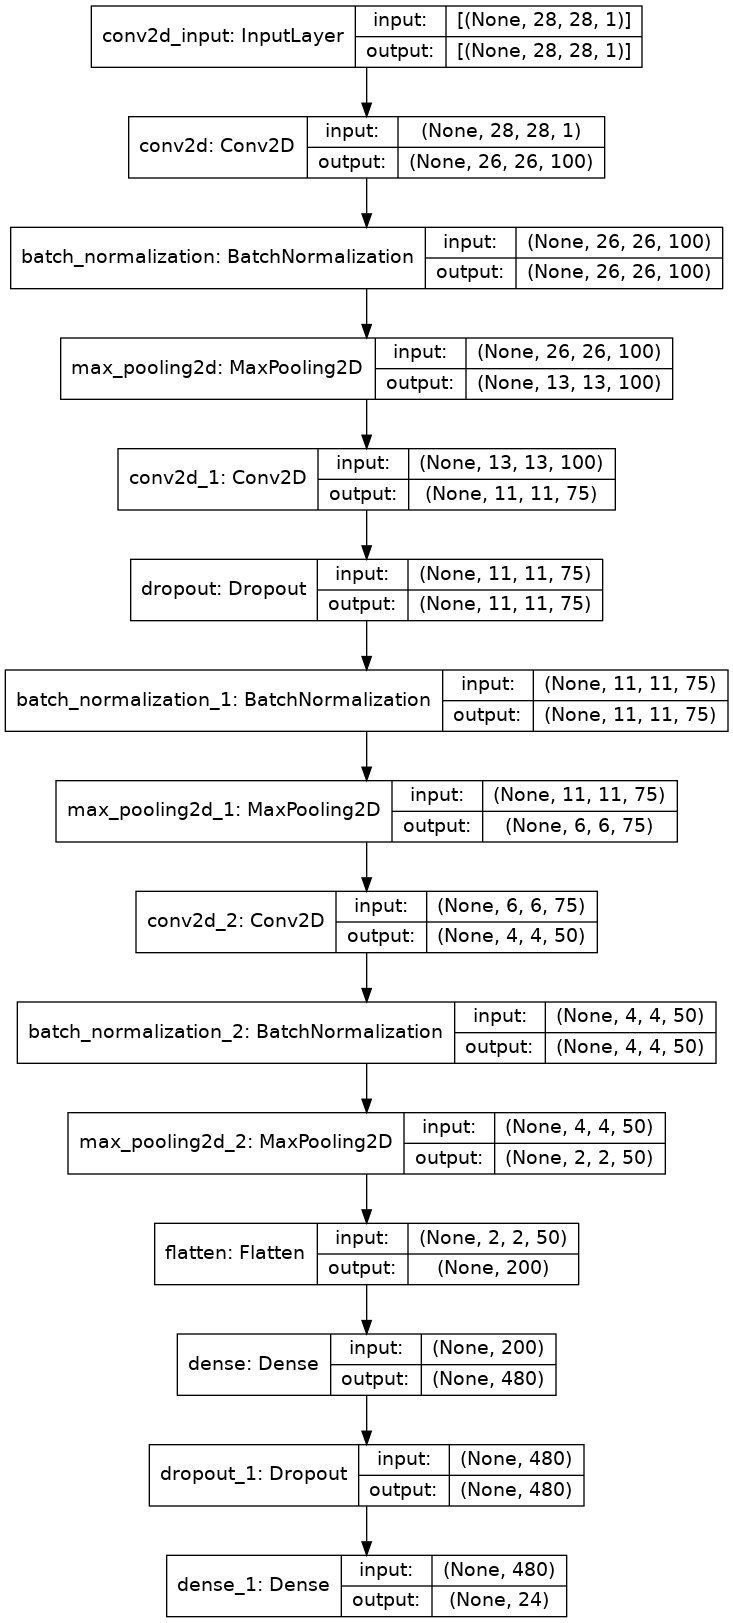

In [22]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

Now let's make some predictions on test data and see the confusion metrix

In [23]:
predictions = model.predict(test_x)

In [24]:
def predictions_to_labels(pred):
    labels =[]
    for p in pred:
        labels.append(unique_labels[np.argmax(p)])
    return labels

In [25]:
y_pred_labels = predictions_to_labels(predictions)
y_test_labels = predictions_to_labels(y_test)

In [26]:
accuracy_score(y_test_labels,y_pred_labels)

0.9988845510317903

<AxesSubplot:>

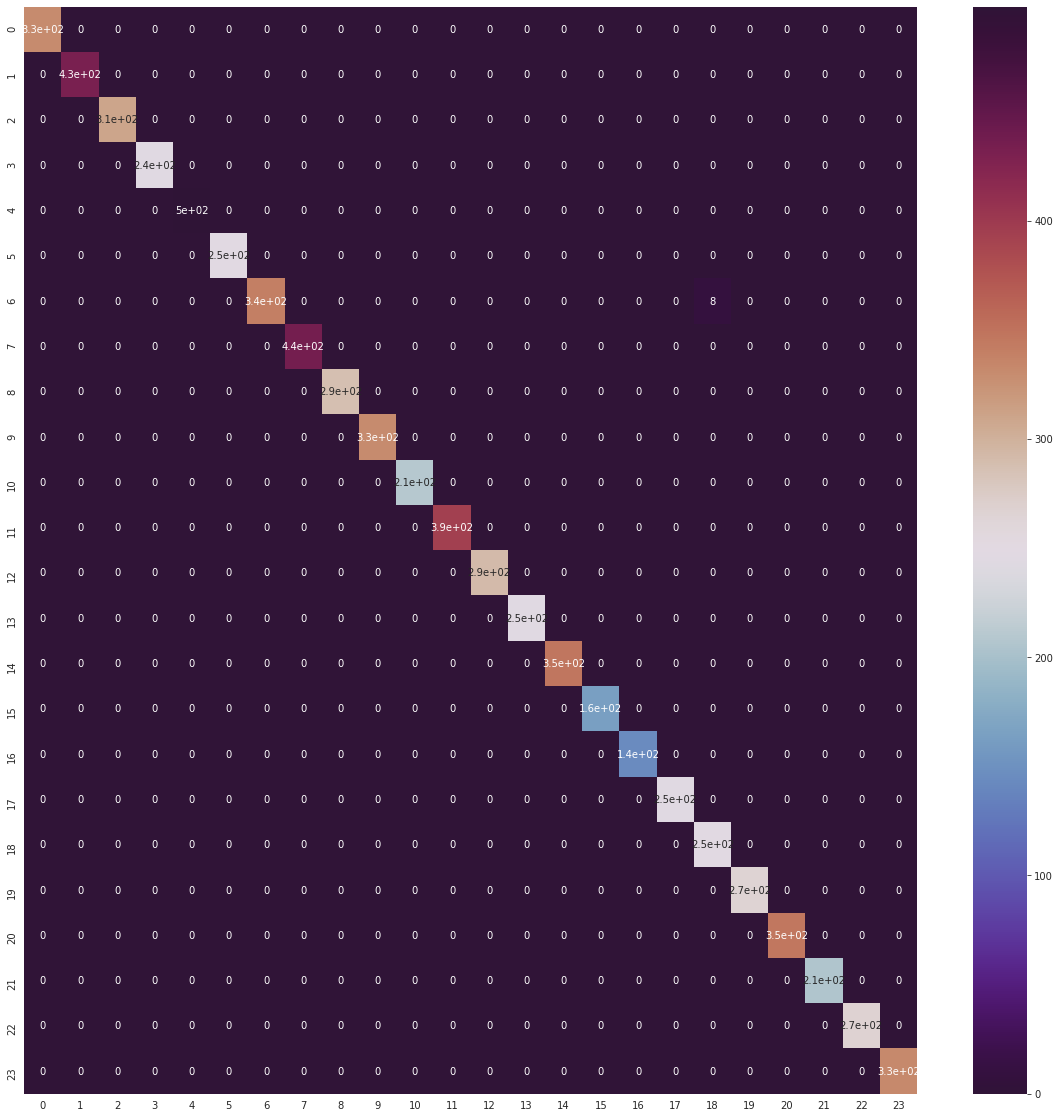

In [27]:
cm= confusion_matrix(y_test_labels,y_pred_labels)
plt.figure(figsize=(20,20))
sns.heatmap(cm,annot=True,cmap='twilight_shifted')

<p style = "font-size : 30px; color : #03506f ; font-family : 'Comic Sans MS'; "><strong>Conclusion</strong></p> 
 * we took the data from the dataframes and preprocessed the images <br>
 * we performed data augmentation </br>
 * we creadted a cnn model and tuned the hyperparameters with the help of `keras-tuner` library</br>
 * we analysed our model 
<br>
<p style = "font-size : 25px; color : #035d6f ; font-family : 'Comic Sans MS'; ">At the end me made prediction of test data and as you can see we got the accuracy of <strong>100%</strong></p> 